# RBM PCD used on MNIST Data

To approach the larger datasets, there are some features needed by the model. 

Firstly is a decreasing learning rate with restarts. With a larget data set, instead of simply spending more training time, I think it's wise to try a decreasing learning rate with restarts. This could speed up learning while preventing the algorithm in getting stuck in a local minima, allowing more exploration of the model space. 

Secondly is minibatch learning. The basic form of the algorithm only uses whole datasets. Due to the larger dataset involved in real applications, minibatch learning is required due to memory limitation and to further prevent overfitting.

In [455]:
import pandas as pd

In [456]:
PATH = "MNIST Data/"
train_path = f"{PATH}train.csv"
test_path = f"{PATH}test.csv"

In [457]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

In [458]:
test.shape

(28000, 784)

In [459]:
test_sub = test.iloc[:10, :]
test_sub.shape

(10, 784)

In [528]:
test_data = test_sub.values/255

In [529]:
val_data = test.iloc[11:21, :].values/255

In [510]:
val_data.shape

(9, 784)

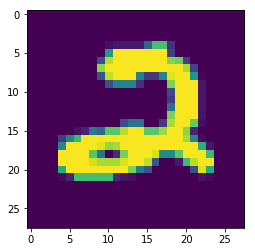

In [478]:
plt.imshow(test_data[0,:].reshape(28, 28))

# RBM class implementation with Constrastive Divergence

Restricted Boltzmann Machine (RBM) is an algorithm that is based on the Boltzmann Machine. The idea was proposed by Geoffrey Hinton (2002) and has since been used to tackle many problems successfully, even beating out many advanced feed-forward networks. 

The architecture consists of 1 visible and 1 hidden unit. Every visible unit is linked to every hidden unit, but each hidden unit is independent from one another. The weights that connects the two layers are symmetrical. 

RBM is an unsupervised learning algorithm. There is no target function to minimize. Instead, it is a form of auto-encoder. The weights are adjusted such that the input can be reconstructed accurately. 

There are a number of possible learning method for the RBM. Here I present the most basic learning algorithm, the Contrastive Divergence algorithm. This algorithm compares the reconstructed input after k-steps to the initial input and updates the weight based on this difference. Take note that unlike a feed-forward network, the algorithm is probabilistic in nature. It does not back-propagate any error function to update the weights as there are no error function to evaluate.

In this implementation we did not use a fixed LR. Instead we decrease the LR as the learning progresses. This is achieved by dividing the LR with the epoch. A possibility this allows is to have stochastic learning with restarts. Following the idea used in gradient descent called SGD with restarts, we feel that there is benefit in applying the method to RBM learning. This idea is explored in a later segment of the experiment.

To monitor the learning performance, we plot the squared difference between the reconstructed mean and the input, the error function, as well as the weights distribution.

In [3]:
import numpy as np
from matplotlib import pyplot as plt

## Class Implementation Details

The idea is based on the programming assignment of the Neural Network Assignment by Geoffrey Hinton on Coursera. Implementation as a class makes it easier to use in future projects and opens much more possibility for method expansions.

The implementation also includes methods to display error and weight histogram to make monitoring of the learning process easier. 

In [643]:
class RBM(object):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        """
        Creates an RBM model based on the input parameter from a Numpy Array
        
        Matrix Sizes:
        V = sample_size x n_visible
        H = sample_size x n_hidden
        W = n_visible x n_hidden
        
        Parameters:
        input = input matrix for the RBM.
        n_visible = number of visible UNITS. this has to align with the input dimensions
        n_hidden = number of hidden UNITS.
        W = initialized weights matrix. if None, weight will be initialized by the model 
            using a uniform distribution that is proportional to n_visible
        h_vias = hidden unit bias vector
        v_bias = visible unit bias vector
        numpy_rng = random seed to ensure consistency in calculation. 
                    if left as None, random seed will be intialized by the model
            
        """
        self.n_visible = n_visible #num of visible unit
        self.n_hidden = n_hidden #num of hidden unit
        
        if numpy_rng is None:
            numpy_rng = np.random.RandomState(123)
            
        if W is None:
            a = 1. / n_visible
            initial_W = np.array(numpy_rng.uniform(
                        low = -a, 
                        high = a, 
                        size = (n_visible, n_hidden)
                            )
                        )
            W = initial_W
        
        self.sample_size = data.shape[0]
        
        if hbias == None:
            hbias = np.zeros((self.sample_size,n_hidden))
        
        if vbias == None:
            vbias = np.zeros((self.sample_size,n_visible))
        
        self.numpy_rng = numpy_rng
        self.hbias = hbias
        self.vbias = vbias
        self.W = W
        
        self.input = input
        self.energy_plot = []
        self.error_plot = []
        
        self.W_momentum = np.zeros((n_visible, n_hidden))
        self.hbias_momentum = np.zeros((self.sample_size, n_hidden))
        self.vbias_momentum = np.zeros((self.sample_size, n_visible))
        
    def contrastive_divergence(self, lr = 0.1, k = 1, momentum = 0.9, wd = 0.1):
        """
        Performs contrastive divergence of on the model. 
        
        Parameters:
        lr = learning rate. default = 0.1
        k = number of steps for the CD algorithm. default = 1, i.e. CD1
        
        Outputs:
        energy = energy of the current RBM model after k-steps of input reconstruction
        error = error between reconstructed output after k-steps to the initial input
        """
        ph_mean, ph_sample = self.get_hid_state(self.input)
        
        cur_sample = ph_sample
        
        for step in range(k):
            nv_mean, nv_sample = self.get_vis_state(cur_sample)
            nh_mean, nh_sample = self.get_hid_state(nv_sample)
            cur_sample = nh_sample
                
        delta_W = lr * (np.dot(self.input.T,ph_sample) - np.dot(nv_sample.T,nh_sample))
        delta_hbias = (momentum * np.sum(self.hbias_momentum) + lr * np.sum(ph_sample - nh_sample))/self.sample_size
        delta_vbias = (momentum * np.sum(self.vbias_momentum) + lr * np.sum(self.input - nv_sample)) /self.sample_size
        
        W_momentum = momentum * self.W_momentum - (1 - momentum)*delta_W
        
        self.W_momentum = W_momentum 
        self.hbias_momentum = delta_hbias
        self.vbias_momentum = delta_vbias
        
        weight_cost = np.sum(self.W)
        
        self.W = self.W + delta_W - lr*wd*weight_cost
        self.hbias += delta_hbias 
        self.vbias += delta_vbias 
                      
        energy = self.get_energy(v = nv_mean, h = nh_mean)
        error = self.get_error(v_init = self.input, v_recon = nv_mean)
        
        return [energy, error]
        
    def propup(self, v):
        z = np.dot(v, self.W) + self.hbias
        return self.sigmoid(z)
    
    def propdown(self, h):
        z = np.dot(self.W, h.T).T + self.vbias
        return self.sigmoid(z)
    
    def get_hid_state(self, v_sample):
        h_mean = self.propup(v_sample)
        h_sample = self.numpy_rng.binomial(size = h_mean.shape, 
                                            n = 1, #bernoulli distribution
                                            p = h_mean)
        return [h_mean, h_sample]
    
    def get_vis_state(self, h_sample):
        v_mean = self.propdown(h_sample)
        v_sample = self.numpy_rng.binomial(size = v_mean.shape, 
                                            n = 1, 
                                            p = v_mean)
        return [v_mean, v_sample]
      
    def get_energy(self, v = None, h = None): 
        energy = -np.sum(np.multiply(np.dot(v.T, h), self.W)) - np.sum(np.dot(self.vbias, v.T)) - np.sum(np.dot(self.hbias, h.T))
        return energy
    
    def get_error(self, v_init = None, v_recon = None):
        error = np.sum(np.square(v_init - v_recon))
        return error
        
    def sigmoid(self, x):
        return 1/(1 + np.exp(-x))
    
    def train(self, n_epoch = 1000, lr = 0.1, k = 1, momentum = 0.9, wd = 0.1):
        """
        Training function. Calculates contrastive divergence to update the weight
        and stores energy and error values
        
        Paramters:
        n_epoch = number of epoch. default = 1000
        lr = learning rate. default = 0.1
        k = CD step number. default = 1    
        """
        momentum_init = momentum
        for epoch in range(n_epoch):
            momentum_ = 0.99 - ((0.99 - momentum_init)/(epoch + 1))
            lr_ = lr/(epoch+1)
            energy, error = self.contrastive_divergence(lr = lr_, 
                                                        k = k, 
                                                        momentum = momentum_,
                                                        wd = wd)
            self.energy_plot.append(energy)
            self.error_plot.append(error)
            if (epoch + 1) % 100 == 0:
                print('training epoch %s, energy is %.4f, error is %.4f' % (epoch + 1, energy, error))
                
    
    def plot_energy(self, n_window = 100):
        """
        Plots an energy function of the model.
        Useful metric to use to monitor learning process.
        
        Parameters:
        n_window = the window size for moving average of the model. 
        """
        energy_plot = []
        cumsum = [0]
        for i, energy in enumerate(self.energy_plot):
            cumsum.append(cumsum[i-1] + energy)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i - n_window])/n_window
                energy_plot.append(moving_ave)
            
        plt.plot(energy_plot)
        plt.show()
        
    def plot_error(self, n_window = 100):
        """
        Plots the sum of squared error between the reconstructed input and the original input.
        Useful metric to use to monitor learning process.
        
        Parameters:
        n_window = the window size for moving average of the model. 
        """
        error_plot = []
        cumsum = [0]
        for i, error in enumerate(self.error_plot):
            cumsum.append(cumsum[i - 1] + error)
            if i >= n_window:
                moving_ave = (cumsum[i] - cumsum[i-n_window])/n_window
                error_plot.append(moving_ave)
        
        plt.plot(error_plot)
        plt.show()
    
    def disp_weights(self, n_bins = 10):
        """
        Debugging function to show the weights distribution
        Useful metric to use to monitor learning process.
        """
        #print(self.W)
        plt.hist(self.W.reshape((self.n_visible * self.n_hidden, 1)), bins = n_bins)
        plt.show()
    
    def predict(self, input = None, row = 0):
        if input is None:
            input = self.input
        hid_mean, hid_state = self.get_hid_state(input)
        vis_mean, vis_state = self.get_vis_state(hid_state)

        plt.subplot(231)
        plt.imshow(input[row,:].reshape(28,28))
        plt.title("original")
        plt.subplot(232)
        plt.imshow(vis_state[row,:].reshape(28,28))
        plt.title("reconstructed")
        plt.subplot(233)
        plt.imshow(vis_mean[row,:].reshape(28,28))
        plt.title("recon mean")
        
        plt.subplot(234)
        plt.imshow(self.W)
        plt.title("weights")
        plt.show()

TODO: Add Momentum to Learning

link: https://www.ii.pwr.edu.pl/~gonczarek/papers/drbm_nesterov.pdf

In [584]:
'''
data = np.array([[1,1,1,0,0,0],
                 [1,0,1,0,0,0],
                 [1,1,1,1,1,1],
                 [0,0,0,1,0,1],
                 [0,0,0,1,1,1],])
'''
data = test_data
rng = np.random.RandomState(123)
n_visible = data.shape[1]
n_hidden = 1500
W = rng.normal(loc = 0., scale = 0.1, size = (n_visible, n_hidden))

In [585]:
rbm = RBM(input = data, n_visible = n_visible, n_hidden = n_hidden, W = W, numpy_rng = rng)

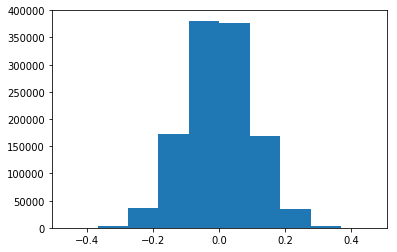

In [586]:
rbm.disp_weights()

In [587]:
rbm.train(lr = 0.005, k = 1, n_epoch = 100, momentum = 0.5, wd= 0.0001)

training epoch 100, energy is 88681.4333, error is 266.1429


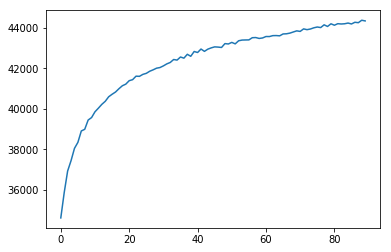

In [590]:
rbm.plot_energy(10)

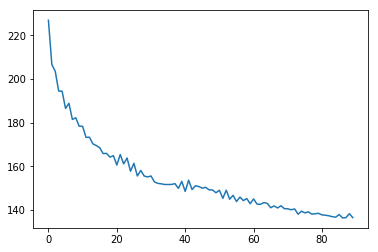

In [591]:
rbm.plot_error(10)

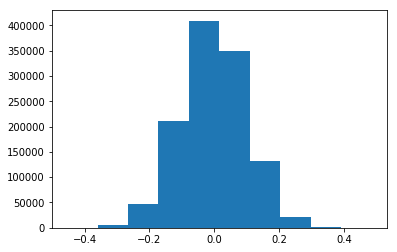

In [592]:
rbm.disp_weights()

## Results of the RBM with CD algorithm

Due to the crude nature of CD learning algorithm whereby the model is restarted to the initial point at every step of the learning, the model term of the weight update expression is too far from the ideal model parameter. This can be seeen from the reconstructed result compared to the initial input below.

In the next section I will improve on this using the Persistent Contastive Divergence method.

In [593]:
vali = np.array([[1,0,0,0,0,1],
                 [1,0,0,0,0,1],
                 [1,0,0,0,0,1],
                 [1,1,1,1,1,1],
                 [0,0,0,0,0,0],])

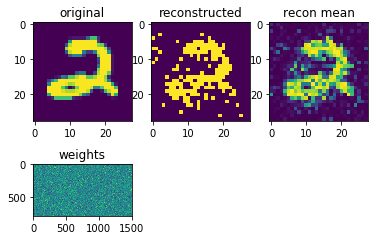

In [594]:
rbm.predict()

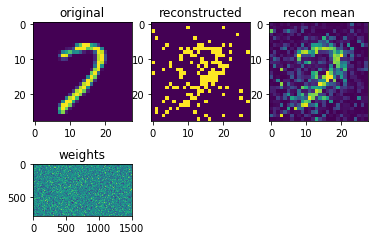

In [595]:
rbm.predict(input = val_data)

# RBM with Persistent CD algorithm

Persistent Contrastive Divergence is a variant of the contrastive divergence algorithm illustrated above. However, instead of restarting the Markov Chain everytime the contrastive divergence, we allow the Markov Chain to run continuously. This is achieved by having the result of the previous Chain stored and used in the next chain. 

By having the Chain run continously, the model is able to move much further along the model space than traditional Contrastive Divergence. As a result, with subsequent iteration, the configuration gets closer to the ideal equilibrium configuration, making the reconstruction much more accurate. 


In [644]:
class RBM_PCD (RBM):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        RBM.__init__(self, input, n_visible, n_hidden, W, hbias, vbias, numpy_rng)
        
        self.V_mean, self.V_persistent = np.zeros(self.input.shape), self.input
        self.H_mean, self.H_persistent = self.get_hid_state(self.V_persistent)
        
    def PCD (self, lr = 0.01, k = 1, wd = 0.9, momentum = 0.9):
        """
        Updates weight using PCD algorithm. 
        
        Parameters:
        lr = Learning Rate
        k = CD step to take before weight update
        
        Output:
        error = squared error between reconstructed input and actual input
        energy = energy of the reconstructed model
        """
        ph_mean, ph_sample = self.get_hid_state(self.input)
        
        for step in range(k):
            self.V_mean, self.V_persistent = self.get_vis_state(self.H_persistent)
            self.H_mean, self.H_Persistent = self.get_hid_state(self.V_persistent)
                
        delta_W = lr * (np.dot(self.input.T,ph_sample) - np.dot(self.V_mean.T,self.H_mean))
        delta_hbias = (momentum * np.sum(self.hbias_momentum) + lr * np.sum(ph_sample - self.H_mean))/self.sample_size
        delta_vbias = (momentum * np.sum(self.vbias_momentum) + lr * np.sum(self.input - self.V_mean)) /self.sample_size
        
        W_momentum = momentum * self.W_momentum - (1 - momentum)*delta_W
        
        self.W_momentum = W_momentum 
        self.hbias_momentum = delta_hbias
        self.vbias_momentum = delta_vbias
        
        weight_cost = np.sum(self.W)
        
        self.W = self.W + delta_W - lr*wd*weight_cost
        self.hbias += delta_hbias 
        self.vbias += delta_vbias 
                      
        energy = self.get_energy(v = self.V_mean, h = self.H_mean)
        error = self.get_error(v_init = self.input, v_recon = self.V_mean)
        
        return [energy, error]
    
    def train(self, n_epoch = 100, lr = 0.005, k = 1, wd = 0.0001, momentum = 0.5):
        momentum_init = momentum
        for epoch in range(n_epoch):
            
            momentum_ = 0.99 - ((0.99 - momentum_init)/(epoch + 1))
            lr_ = lr/(epoch+1)
            
            energy, error = self.contrastive_divergence(lr = lr_, 
                                                        k = k, 
                                                        momentum = momentum_,
                                                        wd = wd)
            energy, error = self.PCD(lr = lr/(epoch + 1), 
                                     k = k, 
                                     wd = wd)
            self.energy_plot.append(energy)
            self.error_plot.append(error)
            if (epoch + 1) % 100 == 0:
                print('training epoch %s, energy is %s, error is %s' % (epoch + 1, energy, error))
                
            

In [645]:
data = test_data
rng = np.random.RandomState(123)
n_visible = data.shape[1]
n_hidden = 1500
W = rng.normal(loc = 0., scale = 0.1, size = (n_visible, n_hidden))

In [646]:
rbm_pcd = RBM_PCD(input = data, n_visible = n_visible, n_hidden = n_hidden, W = W, numpy_rng = rng)

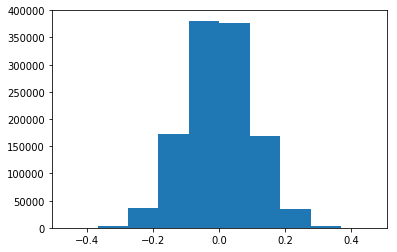

In [647]:
rbm_pcd.disp_weights()

In [648]:
rbm_pcd.train(lr = 0.005, k = 1, n_epoch = 100, wd = 0.0001, momentum = 0.5)

training epoch 100, energy is 106061.97932973382, error is 268.92258321441943


# Learning Process with RBM and PCD Learning Algorithm

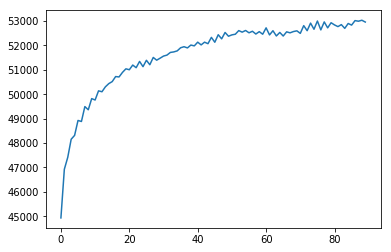

In [649]:
rbm_pcd.plot_energy(10)

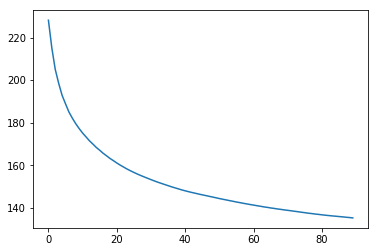

In [650]:
rbm_pcd.plot_error(10)

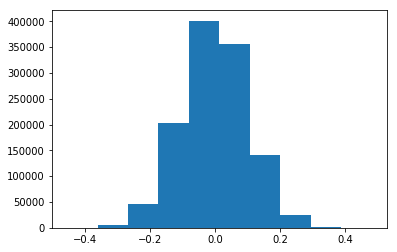

In [651]:
rbm_pcd.disp_weights()

# Results of the RBM learned with PCD

As can be seen, the reconstructed mean resembles the input more compared to when CD1 was used. This comes at the expense of computing power however. For this small toy example, computing power is not big issue. However, as the input data set becomes bigger, learning will take much longer.

In [652]:
vali = np.array([[1,0,0,0,0,1],
                 [1,0,0,0,0,1],
                 [1,0,0,0,0,1],
                 [1,1,1,1,1,1],
                 [0,0,0,0,0,0],])

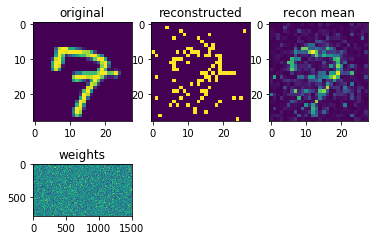

In [659]:
rbm_pcd.predict(row = 5)

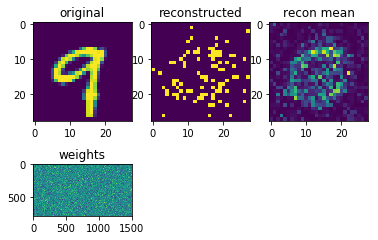

In [668]:
rbm_pcd.predict(input = val_data, row = 9)

Based on this result, it seem that the algorithm is over-fitting to the training dat due to the size. I will try to use a larger data set for subsequent learning.

## Minibatch RBM with CDk step

To prevent memory issues during learning due to the large dataset, we use minibatches in learning. 100 images are used for every update. 

The previous restarts are also implemented to enhance the minibatch learning effect. 

In [44]:
class RBM_mini_batch(RBM):
    def __init__ (self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        RBM.__init__(self, input, n_visible, n_hidden, W, hbias, vbias, numpy_rng)
     
    def train(self, n_epoch = 1000, lr = 0.1, k = 1, wd = 0.9, momentum = 0.5, bs = 32):
        

(1000, 784)

# Decreasing Learning Rate with Restarts

The idea of the decreasing learning rate with restarts is to start at a higher learning rate and reduce the learning rate as learning progresses. At some point during learning, the LR is again pushed back up to the starting value and decreased again. This restarts can be done as many times as needed during learning.  This idea stems from the SGD with restarts that is done in many feed-forward networks.

The idea of restarts is to ensure that the model can escape any local minima that it has settled into during the previous descent. Although RBMs is not a minimization algorithm, looking at the constantly decreasing energy and error value of each restart, there might be some benefit to be reaped at this approach. 

In [ ]:
class RBM_restarts(RBM):
    def __init__(self, input = None, n_visible = 1, n_hidden = 1, 
                W = None, hbias = None, vbias = None, numpy_rng = None):
        RBM.__init__(self, input, n_visible, n_hidden, W, hbias, vbias, numpy_rng)
    
    def train_restarts(self, n_epoch = 20, lr = 0.1, k = 1, wd = 0.9, batch_size = 50):